In [1]:
%cd ..

/users/fzanetta/pyprojects/bernstein-flow


/scratch-shared/meteoswiss/scratch/fzanetta/mambaforge/envs/jax/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import typing as tp
import functools as ft

import numpy as np
import jax
import jax.numpy as jnp
import jax.random as jr
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from flax.experimental import nnx
import optax as ox
from jaxtyping import Float, Array
import scoringrules as sr

from bernstein_flow.distribution import BernsteinFlow
from swagp.data.preproc import Partitioner, Standardizer
from swagp.data.dataset import Dataset
from swagp._vscan import vscan

sr.register_backend("jax")

In [3]:
def dataloader(x, y, batch_size, *, key, shuffle=True):
    dataset_size = x.shape[0]
    indices = jnp.arange(dataset_size)
    perm = indices
    while True:
        if shuffle:
            perm = jr.permutation(key, indices)
        (key,) = jr.split(key, 1)
        start = 0
        end = batch_size
        while end < dataset_size:
            batch_perm = perm[start:end]
            yield jnp.array(x[batch_perm]), jnp.array(y[batch_perm])
            start = end
            end = start + batch_size


class BernsteinFlowRegressor(nnx.Module):
    def __init__(
        self,
        din: int,
        hidden: list[int],
        dout: int,
        *,
        key: jax.Array,
    ):
        h = [din] + hidden
        rngs = [nnx.Rngs(k) for k in jr.split(key, len(h))]
        self.hidden = [nnx.Linear(h[i], h[i + 1], rngs=rngs[i]) for i in range(len(h) - 1)]
        self.hidden = nnx.Sequence(self.hidden)
        self.out = nnx.Linear(hidden[-1], dout, rngs=rngs[-1])
    
    def __call__(self, x: Float[Array, "... Din"]) -> Float[Array, "... Dout"]:
        for layer in self.hidden:
            x = layer(x)
            x = jax.nn.tanh(x)
        return BernsteinFlow(self.out(x))
    
    def fit(
        self: tp.Self,
        x_train: Float[Array, "N Din"],
        y_train: Float[Array, "N Dout"],
        val_data: tuple[Float[Array, "N Din"], Float[Array, "N Dout"]],
        /,
        key: Array,
        opt: ox.GradientTransformation,
        *,
        batch_size: int = 32,
        n_steps: int = 400,
        verbose: bool = True,
    ) -> tuple[tp.Self, dict[str, Array]]:
        x_train, y_train = map(jnp.asarray, (x_train, y_train))
        val_data = tuple(map(jnp.asarray, val_data))

        train_dl = dataloader(
            x_train,
            y_train,
            batch_size=batch_size,
            key=key,
            shuffle=True,
        )

        params, moduledef = self.split()
        train_state = nnx.TrainState(
            moduledef,
            params=params,
            tx=opt,
        )

        iter_keys = jr.split(key, n_steps)

        def step(carry, key):
            key, _ = jr.split(key)
            carry, train_loss = self.train_step(carry, next(train_dl))
            log = self.val_step(carry, val_data)
            log["nll"] = train_loss
            return carry, log

        scan = vscan if verbose else jax.lax.scan
        train_state, history = scan(step, train_state, (iter_keys))
        model = moduledef.merge(train_state.params)

        return model, history

    @ft.partial(jax.jit, static_argnums=0)
    def train_step(self, state: nnx.TrainState, batch):
        x, y = batch
        y = y[..., 0]
        mask = ~jnp.isnan(y)
        y = jnp.where(mask, y, 1.0)

        def loss_fn(params):
            flow, _ = state.apply(params)(x)
            flow: BernsteinFlow
            return jnp.mean(-flow.log_prob(y), where=mask)
        value, grads = jax.value_and_grad(loss_fn)(state.params)
        state = state.apply_gradients(grads=grads)
        return state, value

    @ft.partial(jax.jit, static_argnums=0)
    def val_step(self, state: nnx.TrainState, data):
        x, y = data
        flow, _ = state.apply("params")(x)
        crps = jnp.nanmean(-flow.log_prob(y[...,0]))
        return {"val_nll": crps}

In [4]:
features = [
    "weather:wind_speed_of_gust",
    "weather:wind_speed_of_gust_p1h",
    "weather:wind_speed_of_gust_m1h",
    "weather:sx_500m",
    "time:sin_hourofday",
    "time:cos_hourofday",
    "static:elevation",
    "static:tpi_500m",
    "static:tpi_2000m",
    "static:model_elevation_difference",
    "static:we_derivative_2000m",
    "static:sn_derivative_2000m",
]

target = ["weather:wind_speed_of_gust"]
x = xr.open_zarr("../swagp/data/x.zarr")[features].isel(time=slice(1,-1))
y = xr.open_zarr("../swagp/data/y.zarr")[target].isel(time=slice(1,-1))

seed = 42

# preprocessing: partition, standardize & (optionally) transform
partitioner = Partitioner(y[target[0]], seed=seed)
data = {p: partitioner.get(x, y, p=p) for p in ["train", "val_target"]}

standardizer = Standardizer.fit(data["train"][0], dims=("time","station"))
# standardizer.scale["static:easting"].values = standardizer.scale["static:northing"].values
for k, v in data.items():
    data[k][0] = standardizer.transform(v[0])

train = Dataset.from_xarray(*data["train"])
val_target = Dataset.from_xarray(*data["val_target"])


In [5]:
np.nanmin(train.y)

0.2

In [38]:

net = BernsteinFlowRegressor(
    din=train.x.shape[-1],
    hidden=[128, 64],
    dout=24,
    key=jr.PRNGKey(42),

)


  0%|          | 0/1000 [00:00<?, ?it/s]

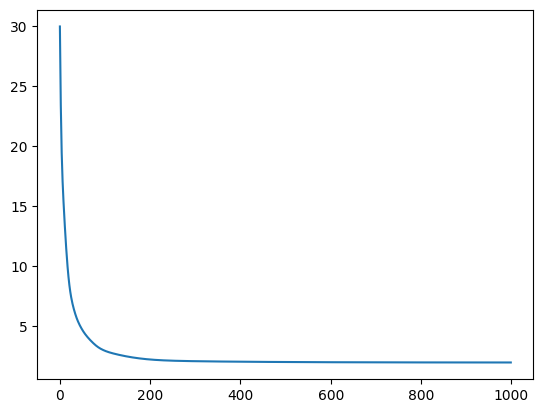

In [39]:
jax.config.update("jax_disable_jit", False)

net, history = net.fit(
    train.x.reshape(-1, len(features)),
    train.y.reshape(-1, len(target)),
    (val_target.x.reshape(-1, len(features))[::30], val_target.y.reshape(-1, len(target))[::30]),
    key=jr.PRNGKey(42),
    opt=ox.adabelief(7e-4),
    batch_size=2 ** 14,
    n_steps=1000,
)

plt.plot(history["val_nll"])

[[3.3]]
0.25284368


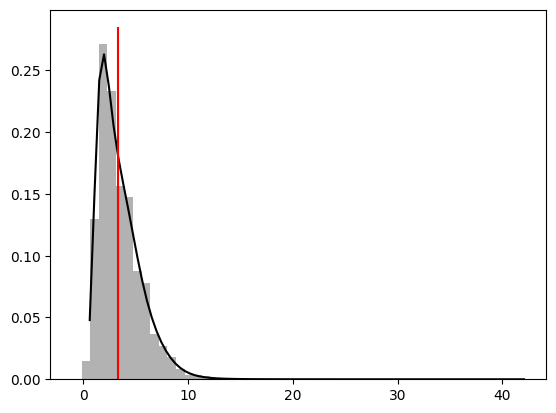

In [81]:
tidx = np.random.randint(0, 1000)
sidx = np.random.randint(0, 70)
pred_flow = net(val_target.x[[tidx],sidx])
print(val_target.y[[tidx],sidx])
seed = np.random.randint(0, 2 ** 32)
samples = np.array(pred_flow.sample(seed=seed, sample_shape=(1000,))).squeeze()
print(np.nanmin(samples))
fig, ax = plt.subplots()
ax: plt.Axes 
ax.hist(samples[np.isfinite(samples)], bins=50, density=True, alpha=0.3, color="k", range=(-1, 40));
yy = jnp.linspace(*ax.get_xlim(), 100)[:,None]
prob = pred_flow.prob(yy)
ax.plot(yy, prob, color="k");
ax.vlines(val_target.y[[tidx],sidx][0,0], *ax.get_ylim(), color="red");

shift [-1.6592832]
scale [0.6470032]
BernsteinBijector [[-2.2993875  -1.6014888  -0.7375486   0.02334094  0.67192185  1.5434808
   1.9295746   2.3741083   2.6008956   2.8425584   3.1622825   3.5180721
   4.024599    4.312515    4.744067    4.9972935   5.590564    6.300064
   7.2059245   7.541716  ]]
soft_clip None
shift [-0.20830153]
scale [0.42917293]
invert_soft_clip None
shift -0.1999


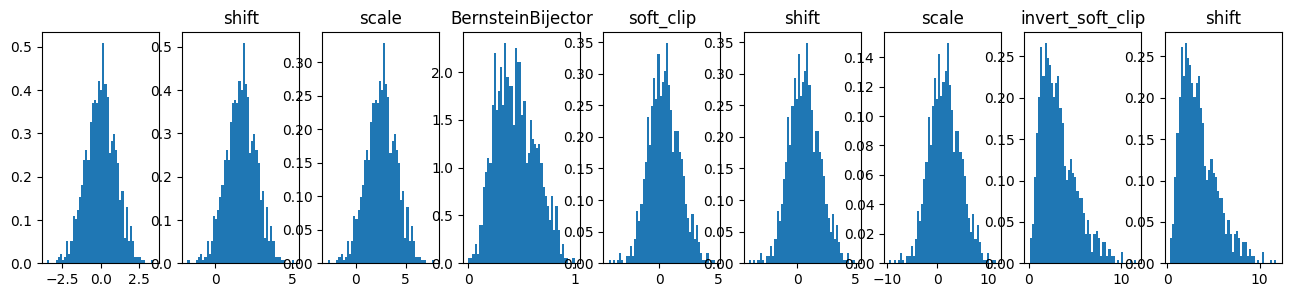

In [82]:
x = np.random.randn(1000,1)

bijs = pred_flow.bijector.bijector.bijectors.copy()
fig, axs = plt.subplots(1, len(bijs)+1, figsize=(16, 3))
axs[0].hist(x, bins=50, density=True)
for i, bj in enumerate(bijs):
    x = bj.inverse(x)
    axs[i+1].hist(np.array(x).squeeze(), bins=50, density=True);

    if bj.name == "shift":
        val = bj.shift
    elif bj.name == "scale":
        val = bj.scale
    elif bj.name == "BernsteinBijector":
        val = bj.thetas
    else:
        val = None

    axs[i+1].set_title(bj.name)
    print(bj.name, val)

In [85]:
samples = net(val_target.x.reshape(-1, len(features))).sample(seed=42, sample_shape=(51,)) + 0.02
fcts = np.array(samples).T
obs = np.array(val_target.y.reshape(-1))

<Axes: title={'center': 'Thresholded PIT histogram (t = 0.3)'}>

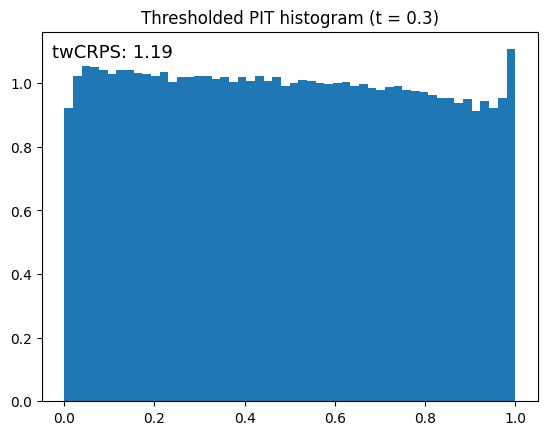

In [86]:

def pit_histogram(
    pred: np.ndarray,
    obs: np.ndarray,
    ax: plt.Axes,
    crps: bool = True,
    bins: int = 100,
    threshold: float | None = None,
) -> plt.Axes:

    pit = np.mean(pred <= obs[..., None], axis=-1)

    if threshold:
        pit_thresh = np.mean(pred <= threshold, axis=-1)
        pit_thresh = np.where(pit_thresh == 1.0, np.nan, pit_thresh)
        pit = (pit - pit_thresh) / (1 - pit_thresh)
        pit[obs <= threshold] = np.nan

    pit[np.isnan(obs) | np.isnan(pred).any(axis=-1)] = np.nan

    ax.hist(np.array(pit.ravel()), density=True, bins=bins)
    ax.set_aspect("auto")
    ax.set_title(f"Thresholded PIT histogram (t = {threshold})" if threshold else "PIT histogram")

    if crps:
        if threshold:
            crps_ = sr.twcrps_ensemble(
                pred, obs, lambda x: np.maximum(threshold, x)
            )
            res = np.nanmean(crps_)
            del crps_
            ax.text(0.02, 0.93, f"twCRPS: {res:.03}", transform=ax.transAxes, fontdict={"size": 13})
        else:
            res = np.nanmean(sr.crps_ensemble(pred, obs))
            ax.text(0.02, 0.93, f"CRPS: {res:.03}", transform=ax.transAxes, fontdict={"size": 13})

    return ax

fig, ax = plt.subplots()
pit_histogram(fcts, obs, ax, bins=52, threshold=0.3)

In [49]:
np.nanmin(samples)

0.09990006

In [95]:
we = val_target.wrap_pred(samples.reshape((*val_target.y.shape[:-1], 51)))

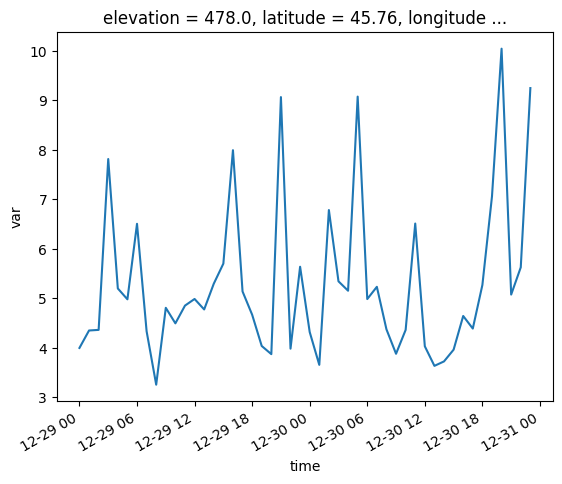

In [102]:
we[-48:,20].mean("realization").plot()

In [109]:
(samples > 70).sum()

Array(15, dtype=int32)

In [131]:
idx = we.max("realization").argmax(["time","station"])
print(val_target.to_xarray()[1]["weather:wind_speed_of_gust"].isel(idx).values)
print(we.max("realization").isel(idx).values)


2.3
99.30666


In [130]:
x = xr.open_zarr("../swagp/data/x.zarr")[features].isel(time=slice(1,-1))
x.isel(idx)["weather:wind_speed_of_gust"].values

array(19.479239, dtype=float32)